In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import shutil
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
!pip install wandb -qU
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
root_dir = '/content/fmnist_train_data'
os.makedirs(root_dir, exist_ok=True)
# change the range to number of classes in dataset
for i in range(10):
    os.makedirs(os.path.join(root_dir, str(i)), exist_ok=True)

In [5]:
trainset = torchvision.datasets.FashionMNIST(root=root_dir, train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

100%|██████████| 26421880/26421880 [00:07<00:00, 3339353.77it/s]


Extracting /content/fmnist_train_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171574.41it/s]


Extracting /content/fmnist_train_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 849620.68it/s] 


Extracting /content/fmnist_train_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7645990.44it/s]

Extracting /content/fmnist_train_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



In [6]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
def save_images_to_folders(dataset, root_dir):
    for idx, (image, label) in enumerate(tqdm(dataset)):
        label_dir = os.path.join(root_dir, str(label))
        img_path = os.path.join(label_dir, f'{idx}.png')
        torchvision.utils.save_image(image, img_path)

In [8]:
save_images_to_folders(trainset, root_dir)

100%|██████████| 60000/60000 [00:41<00:00, 1451.08it/s]


In [10]:
shutil.rmtree('/content/fmnist_train_data/FashionMNIST')

In [11]:
test_dir = '/content/fmnist_test_data'
os.makedirs(test_dir, exist_ok=True)
for i in range(10):
    os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

testset = torchvision.datasets.FashionMNIST(root=test_dir, train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(trainset, batch_size=1, shuffle=True)

100%|██████████| 26421880/26421880 [00:12<00:00, 2119952.26it/s]


Extracting /content/fmnist_test_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/fmnist_test_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172362.74it/s]


Extracting /content/fmnist_test_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/fmnist_test_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3121451.54it/s]


Extracting /content/fmnist_test_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/fmnist_test_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9271050.66it/s]

Extracting /content/fmnist_test_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/fmnist_test_data/FashionMNIST/raw



In [12]:
shutil.rmtree('/content/fmnist_test_data/FashionMNIST')

In [13]:
save_images_to_folders(testset, test_dir)

100%|██████████| 10000/10000 [00:06<00:00, 1450.36it/s]


In [14]:
import os
import pandas as pd

# initialise annotation file names here

train_annotation = 'annotations_fmnist_train.csv'
test_annotation = 'annotations_fmnist_test.csv'

def create_annotations_csv(root_dir, output_file):
    data = []

    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                if os.path.isfile(file_path):
                    data.append([f"{label}/{file_name}", label])

    df = pd.DataFrame(data, columns=['filepath', 'label'])

    df.to_csv(output_file, index=False)

    print(f"{output_file} file created successfully.")

create_annotations_csv(root_dir, train_annotation)
create_annotations_csv(test_dir, test_annotation)

annotations_fmnist_train.csv file created successfully.
annotations_fmnist_test.csv file created successfully.


In [15]:
config = {
    "learning_rate": 0.01,
    "batch_size": 32,
    "epochs": 10,
}

In [16]:
project_name = 'Conformal Prediction Experiments'
run_name = 'FashionMNIST run'
github_url_base = 'https://github.com/Aadharsh1/ML-Deep-Learning/blob/main/Weights_Biases'
file_name = f'{run_name}.ipynb'
notebook_link = f'{github_url_base}/{project_name}/{file_name}'

run = wandb.init(
    project=project_name,
    name=run_name,
    notes=notebook_link,
    config=config,
    )

annotations_path = f'/content/{train_annotation}'
labels_at = wandb.Artifact("train_annotations", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

annotations_path = f'/content/{test_annotation}'
labels_at = wandb.Artifact("test_annotations", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

wandb: Currently logged in as: aadharshr-2022 (aadharshr-2022-Singapore Management University). Use `wandb login --relogin` to force relogin


<Artifact test_annotations>

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pandas as pd
from PIL import Image

class NewDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("L")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [21]:
train_dataset = NewDataset(annotations_file=f'/content/{train_annotation}', img_dir=root_dir, transform=transforms.ToTensor())
test_dataset = NewDataset(annotations_file=f'/content/{test_annotation}', img_dir=test_dir, transform=transforms.ToTensor())


In [22]:
from torch.utils.data import DataLoader, random_split
calibration_size = int(0.02*len(train_dataset))
remaining_size = len(train_dataset) - calibration_size
calibration_set, train_set = random_split(train_dataset, [calibration_size, remaining_size])


In [23]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
calib_loader = DataLoader(calibration_set, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

In [24]:
class model1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(490, out_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = model1(1, 10, 10).to(device)

In [25]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=config['learning_rate'])

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [26]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))


def validate_function(model, device, validation_dataloader, loss_function, accuracy_function):
  model.eval()
  model = model.to(device)
  validation_loss = 0
  validation_acc = 0

  with torch.inference_mode():
    for X_val, y_val in tqdm(validation_dataloader):
      X_val , y_val = X_val.to(device), y_val.to(device)
      val_logits = model(X_val)
      val_pred = torch.argmax(val_logits, dim=1)
      validation_acc += accuracy_function(y_val, val_pred)
      validation_loss += loss_function(val_logits, y_val)
  return validation_loss/len(validation_dataloader), validation_acc/len(validation_dataloader)

In [27]:
epochs = config['epochs']
for epoch in range(epochs):
  train_loss, trng_acc = train_function(model, device, train_loader, loss_fn, optimizer)
  val_loss, val_acc = validate_function(model, device, test_loader, loss_fn, accuracy_function)
  wandb.log({
        'training_loss': train_loss,
        'training_accuracy': trng_acc,
        'test_loss': val_loss,
        'test_accuracy': val_acc
    })
  print(f'Epoch {epoch}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f} ')

  0%|          | 0/1838 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: Training Loss: 1.3147, Training Accuracy: 53.3613 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.5521, Training Accuracy: 79.9629 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.4583, Training Accuracy: 83.6031 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.4118, Training Accuracy: 85.2591 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.3809, Training Accuracy: 86.3149 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.3594, Training Accuracy: 87.2127 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: Training Loss: 0.3430, Training Accuracy: 87.5782 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: Training Loss: 0.3284, Training Accuracy: 88.1869 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: Training Loss: 0.3190, Training Accuracy: 88.6238 


  0%|          | 0/1838 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: Training Loss: 0.3101, Training Accuracy: 88.8857 


In [28]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calib_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [29]:
import numpy as np
import matplotlib.pyplot as plt
n = len(calibration_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.8177581

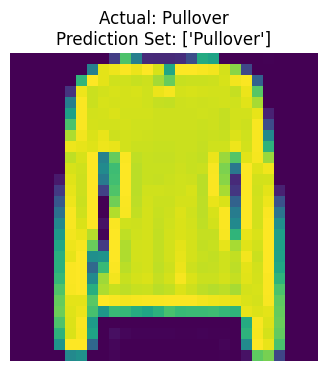

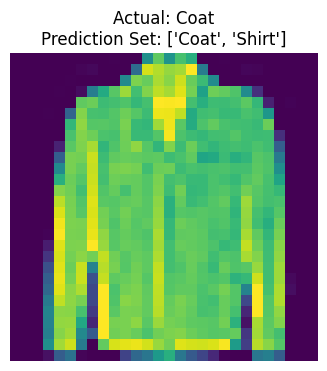

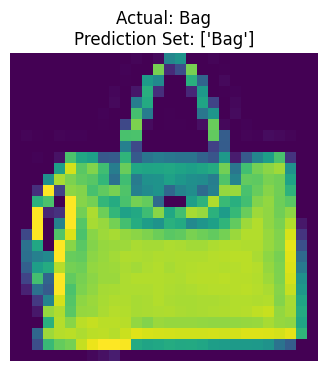

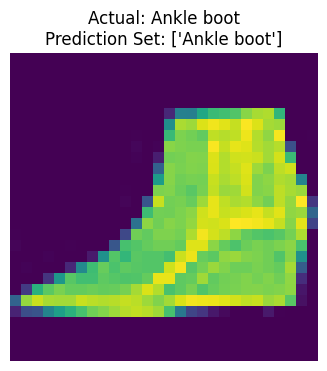

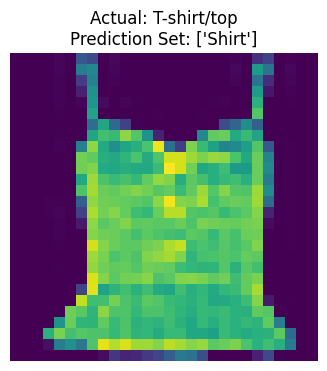

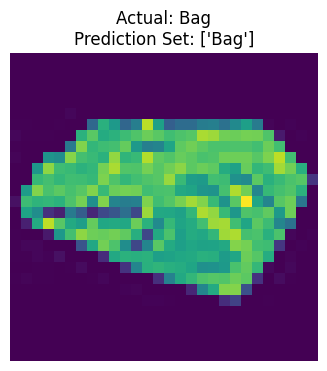

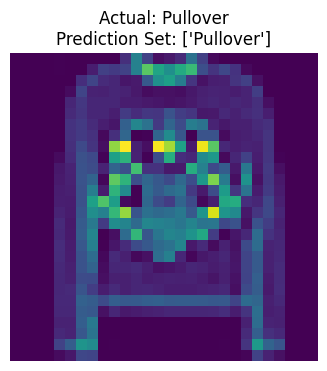

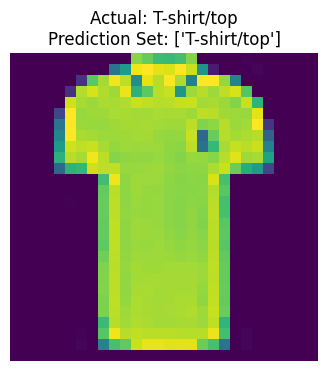

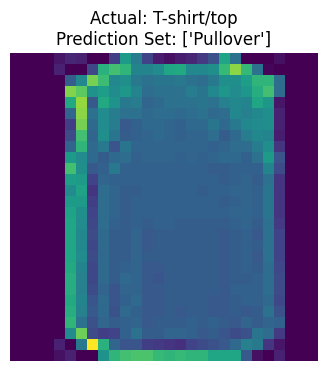

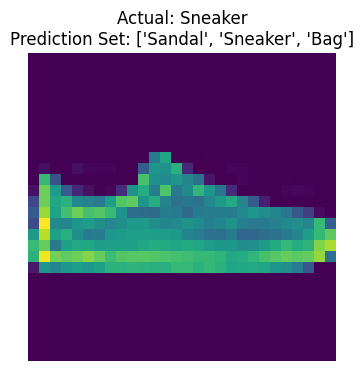

In [30]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(test_dataset)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_dataset, selected_indices)
import matplotlib.pyplot as plt

prediction_sets = []
class_names = trainset.classes
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().squeeze())
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

In [31]:
project_name = wandb.run.project
run_name = wandb.run.name
# change notebook name according to name of current notebook
notebook_path = '/content/drive/MyDrive/Colab Notebooks/fmnist_annotations.ipynb'

In [32]:
url_path = '/content/drive/MyDrive/github_url.txt'
with open(url_path, 'r') as file:
    github_url = file.read().strip()

In [33]:
import os
import subprocess
import shutil
directory = project_name
file_name = f"{run_name}.ipynb"
file_path = os.path.join('/content/ML-Deep-Learning/Weights_Biases', directory, file_name)

In [ ]:
#shutil.rmtree('/content/ML-Deep-Learning')

In [ ]:
repo_path = '/content/ML-Deep-Learning'
if not os.path.exists(repo_path):
    subprocess.run(["git", "clone", github_url, repo_path])

os.chdir(repo_path)

In [ ]:
project_directory = os.path.join('Weights_Biases', directory)
if not os.path.exists(project_directory):
    os.makedirs(project_directory)
    print(f"Directory '{project_directory}' created.")
else:
    print(f"Directory '{project_directory}' already exists.")

In [ ]:
shutil.copyfile(notebook_path, file_path)

In [ ]:
!git config --global user.email "aadharshrajagopal1@gmail.com"
!git config --global user.name "Aadharsh1"
!git remote set-url origin {github_url}

In [ ]:
!cd /content/ML-Deep-Learning/Weights_Biases

In [ ]:
!git add .

In [ ]:
!git commit -m "Add notebook"

In [ ]:
!git push origin main

In [ ]:
wandb.finish()